## Evaluate

In [2]:
import contextlib
from functools import partial
from typing import Any, Dict, List

import json
from omegaconf import OmegaConf
from datasets import DatasetDict, load_dataset
from torch import nn
from transformers import (
    AutoModelForSequenceClassification,
    EarlyStoppingCallback,
    Trainer,
    TrainerCallback,
    TrainingArguments,
)

from mattext.models.utils import (
    CustomWandbCallback_FineTune,
    EvaluateFirstStepCallback,
    TokenizerMixin,
)


/Users/n0w0f/miniconda3/envs/mattext/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class PotentialModel(TokenizerMixin):
    """Class to perform finetuning of a language model.
        Initialize the FinetuneModel.

    Args:
        cfg (DictConfig): Configuration for the fine-tuning.
        local_rank (int, optional): Local rank for distributed training. Defaults to None.
    """

    def __init__(self, cfg, local_rank=None) -> None:
        super().__init__(
            cfg=cfg.representation,
            special_tokens=cfg.special_tokens,
            special_num_token=cfg.special_num_token,
        )
        self.local_rank = local_rank
        self.config = cfg
        self.representation = cfg.representation
        self.alpha = cfg.alpha
        self.test_data = cfg.test_dataset
        self.context_length: int = cfg.context_length
        self.tokenized_testset = self._prepare_datasets(self.test_data, split="test")

    def _prepare_datasets(self, path: str, split) -> DatasetDict:
        """
        Prepare training and validation datasets.

        Args:
            train_df (pd.DataFrame): DataFrame containing training data.

        Returns:
            DatasetDict: Dictionary containing training and validation datasets.
        """

        ds = load_dataset("json", data_files=path, split="train")
        # with contextlib.suppress(KeyError):
        #     ds = ds.remove_columns("labels")
        labal_name = f"total_energy_alpha_{self.alpha}"
        ds = ds.rename_column(labal_name, "labels")

        if split == "train":
            dataset = ds.train_test_split(shuffle=True, test_size=0.2, seed=42)
        else:
            dataset = ds
        # dataset= dataset.filter(lambda example: example[self.representation] is not None)
        return dataset.map(
            partial(
                self._tokenize_pad_and_truncate, context_length=self.context_length
            ),
            batched=True,
        )

    def _callbacks(self) -> List[TrainerCallback]:
        """Returns a list of callbacks for early stopping, and custom logging."""
        callbacks = []

        if self.callbacks.early_stopping:
            callbacks.append(
                EarlyStoppingCallback(
                    early_stopping_patience=self.callbacks.early_stopping_patience,
                    early_stopping_threshold=self.callbacks.early_stopping_threshold,
                )
            )

        if self.callbacks.custom_logger:
            callbacks.append(CustomWandbCallback_FineTune())

        callbacks.append(EvaluateFirstStepCallback)

        return callbacks

    def _compute_metrics(self, p: Any, eval=True) -> Dict[str, float]:
        preds = torch.tensor(
            p.predictions.squeeze()
        )  # Convert predictions to PyTorch tensor
        label_ids = torch.tensor(p.label_ids)  # Convert label_ids to PyTorch tensor

        if eval:
            # Calculate RMSE as evaluation metric
            eval_rmse = torch.sqrt(((preds - label_ids) ** 2).mean()).item()
            return {"eval_rmse": round(eval_rmse, 3)}
        else:
            # Calculate RMSE as training metric
            loss = torch.sqrt(((preds - label_ids) ** 2).mean()).item()
            return {"train_rmse": round(loss, 3), "loss": round(loss, 3)}

    def finetune(self) -> None:
        """
        Perform fine-tuning of the language model.
        """

        pretrained_ckpt = self.config.checkpoint


        model = AutoModelForSequenceClassification.from_pretrained(
            pretrained_ckpt,
            num_labels=1,
            ignore_mismatched_sizes=False
        )
        if self.local_rank is not None:
            model = model.to(self.local_rank)
            model = nn.parallel.DistributedDataParallel(
                model, device_ids=[self.local_rank]
            )
        else:
            model = model.to("cuda")

        trainer = Trainer(
            model=model,
            data_collator=None,
            #callbacks = callbacks
        )

        eval_result = trainer.evaluate(eval_dataset=self.tokenized_testset)
        #predictions = trainer.predict(self.tokenized_testset)
        print(eval_result)
        return eval_result
        

In [4]:
from omegaconf import OmegaConf
properties = [ "matbench_dielectric" , "matbench_log_kvrh", "matbench_perovskites" ]
alphas = [0,0.2,0.4,0.5,0.6,0.8,1]
ckpt_map = {
    0 : "0",
    0.2 : "0_2",
    0.4 : "0_4",
    0.5 : "0_5",
    0.6 : "0_6",
    0.8 : "0_8",
    1 : "1",
}

foldername = "cif_p1"
name = "cif_p1"
context_length = 1024
prop_alpha_result = {}
for prop in properties:
    prop_dict = {}
    for alpha in alphas:
        alpha_string = ckpt_map[alpha]
        test_dataset = f"/work/so87pot/material_db/potential_dataset/normalized/test_{prop}_0.json"
        checkpoint = f"/work/so87pot/mattext/megaloop/finetune/{foldername}_potential_{alpha_string}/checkpoints/finetuned_train_{name}_{prop}_0"
        print(test_dataset,checkpoint)

        config = {
        "representation": name,
        "context_length": context_length,
        "special_num_token": False,
        "alpha": alpha,
        "dataset_name": "matbench_perovskites",
        "test_dataset": test_dataset,
        "checkpoint": checkpoint,
        "special_tokens": {
            "unk_token": "[UNK]",
            "pad_token": "[PAD]",
            "cls_token": "[CLS]",
            "sep_token": "[SEP]",
            "mask_token": "[MASK]",
            "eos_token": "[EOS]",
            "bos_token": "[BOS]"}
        }

        conf = OmegaConf.create(config)
        pot = PotentialModel(conf)
        res = pot.finetune()

        prop_dict[alpha] = res

    key_name = f"{prop}"
    prop_alpha_result[key_name] = prop_dict
#dump results as json

with open(f'prop_alpha_result_{name}.json', 'w') as fp:
    json.dump(prop_alpha_result, fp)





Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x150c5e883b50>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 150c5f1847f0, raw_cell="from omegaconf import OmegaConf
properties = [ "ma.." store_history=True silent=False shell_futures=True cell_id=26b816d4-7b9b-42bb-b856-47cc14946fa2>,),kwargs {}:


TypeError: _resume_backend() takes 1 positional argument but 2 were given

/work/so87pot/material_db/potential_dataset/normalized/test_matbench_dielectric_0.json /work/so87pot/mattext/megaloop/finetune/cif_p1_potential_0/checkpoints/finetuned_train_cif_p1_matbench_dielectric_0
special_tokens: {'unk_token': '[UNK]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'sep_token': '[SEP]', 'mask_token': '[MASK]', 'eos_token': '[EOS]', 'bos_token': '[BOS]'}
['[CLS]', 'Se', '2', 'Se', '3', '[SEP]']


Map:   0%|          | 0/709 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'eval_loss': 0.6619763970375061, 'eval_runtime': 3.109, 'eval_samples_per_second': 228.048, 'eval_steps_per_second': 28.627}
/work/so87pot/material_db/potential_dataset/normalized/test_matbench_dielectric_0.json /work/so87pot/mattext/megaloop/finetune/cif_p1_potential_0_2/checkpoints/finetuned_train_cif_p1_matbench_dielectric_0
special_tokens: {'unk_token': '[UNK]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'sep_token': '[SEP]', 'mask_token': '[MASK]', 'eos_token': '[EOS]', 'bos_token': '[BOS]'}
['[CLS]', 'Se', '2', 'Se', '3', '[SEP]']


Map:   0%|          | 0/709 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'eval_loss': 0.4392726421356201, 'eval_runtime': 3.1099, 'eval_samples_per_second': 227.985, 'eval_steps_per_second': 28.619}
/work/so87pot/material_db/potential_dataset/normalized/test_matbench_dielectric_0.json /work/so87pot/mattext/megaloop/finetune/cif_p1_potential_0_4/checkpoints/finetuned_train_cif_p1_matbench_dielectric_0
special_tokens: {'unk_token': '[UNK]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'sep_token': '[SEP]', 'mask_token': '[MASK]', 'eos_token': '[EOS]', 'bos_token': '[BOS]'}
['[CLS]', 'Se', '2', 'Se', '3', '[SEP]']


Map:   0%|          | 0/709 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'eval_loss': 0.26119759678840637, 'eval_runtime': 3.0933, 'eval_samples_per_second': 229.204, 'eval_steps_per_second': 28.772}
/work/so87pot/material_db/potential_dataset/normalized/test_matbench_dielectric_0.json /work/so87pot/mattext/megaloop/finetune/cif_p1_potential_0_5/checkpoints/finetuned_train_cif_p1_matbench_dielectric_0
special_tokens: {'unk_token': '[UNK]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'sep_token': '[SEP]', 'mask_token': '[MASK]', 'eos_token': '[EOS]', 'bos_token': '[BOS]'}
['[CLS]', 'Se', '2', 'Se', '3', '[SEP]']


Map:   0%|          | 0/709 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'eval_loss': 0.17274989187717438, 'eval_runtime': 3.0965, 'eval_samples_per_second': 228.971, 'eval_steps_per_second': 28.742}
/work/so87pot/material_db/potential_dataset/normalized/test_matbench_dielectric_0.json /work/so87pot/mattext/megaloop/finetune/cif_p1_potential_0_6/checkpoints/finetuned_train_cif_p1_matbench_dielectric_0
special_tokens: {'unk_token': '[UNK]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'sep_token': '[SEP]', 'mask_token': '[MASK]', 'eos_token': '[EOS]', 'bos_token': '[BOS]'}
['[CLS]', 'Se', '2', 'Se', '3', '[SEP]']


Map:   0%|          | 0/709 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'eval_loss': 0.12446816265583038, 'eval_runtime': 3.0959, 'eval_samples_per_second': 229.013, 'eval_steps_per_second': 28.748}
/work/so87pot/material_db/potential_dataset/normalized/test_matbench_dielectric_0.json /work/so87pot/mattext/megaloop/finetune/cif_p1_potential_0_8/checkpoints/finetuned_train_cif_p1_matbench_dielectric_0
special_tokens: {'unk_token': '[UNK]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'sep_token': '[SEP]', 'mask_token': '[MASK]', 'eos_token': '[EOS]', 'bos_token': '[BOS]'}
['[CLS]', 'Se', '2', 'Se', '3', '[SEP]']


Map:   0%|          | 0/709 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'eval_loss': 0.036979224532842636, 'eval_runtime': 3.1035, 'eval_samples_per_second': 228.451, 'eval_steps_per_second': 28.677}
/work/so87pot/material_db/potential_dataset/normalized/test_matbench_dielectric_0.json /work/so87pot/mattext/megaloop/finetune/cif_p1_potential_1/checkpoints/finetuned_train_cif_p1_matbench_dielectric_0
special_tokens: {'unk_token': '[UNK]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'sep_token': '[SEP]', 'mask_token': '[MASK]', 'eos_token': '[EOS]', 'bos_token': '[BOS]'}
['[CLS]', 'Se', '2', 'Se', '3', '[SEP]']


Map:   0%|          | 0/709 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'eval_loss': 0.010472027584910393, 'eval_runtime': 3.1028, 'eval_samples_per_second': 228.505, 'eval_steps_per_second': 28.684}
/work/so87pot/material_db/potential_dataset/normalized/test_matbench_log_kvrh_0.json /work/so87pot/mattext/megaloop/finetune/cif_p1_potential_0/checkpoints/finetuned_train_cif_p1_matbench_log_kvrh_0
special_tokens: {'unk_token': '[UNK]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'sep_token': '[SEP]', 'mask_token': '[MASK]', 'eos_token': '[EOS]', 'bos_token': '[BOS]'}
['[CLS]', 'Se', '2', 'Se', '3', '[SEP]']


Map:   0%|          | 0/1527 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'eval_loss': 0.15715305507183075, 'eval_runtime': 6.7002, 'eval_samples_per_second': 227.905, 'eval_steps_per_second': 28.507}
/work/so87pot/material_db/potential_dataset/normalized/test_matbench_log_kvrh_0.json /work/so87pot/mattext/megaloop/finetune/cif_p1_potential_0_2/checkpoints/finetuned_train_cif_p1_matbench_log_kvrh_0
special_tokens: {'unk_token': '[UNK]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'sep_token': '[SEP]', 'mask_token': '[MASK]', 'eos_token': '[EOS]', 'bos_token': '[BOS]'}
['[CLS]', 'Se', '2', 'Se', '3', '[SEP]']


Map:   0%|          | 0/1527 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'eval_loss': 0.12747929990291595, 'eval_runtime': 6.6725, 'eval_samples_per_second': 228.851, 'eval_steps_per_second': 28.625}
/work/so87pot/material_db/potential_dataset/normalized/test_matbench_log_kvrh_0.json /work/so87pot/mattext/megaloop/finetune/cif_p1_potential_0_4/checkpoints/finetuned_train_cif_p1_matbench_log_kvrh_0
special_tokens: {'unk_token': '[UNK]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'sep_token': '[SEP]', 'mask_token': '[MASK]', 'eos_token': '[EOS]', 'bos_token': '[BOS]'}
['[CLS]', 'Se', '2', 'Se', '3', '[SEP]']


Map:   0%|          | 0/1527 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'eval_loss': 0.05794551968574524, 'eval_runtime': 6.6708, 'eval_samples_per_second': 228.91, 'eval_steps_per_second': 28.632}
/work/so87pot/material_db/potential_dataset/normalized/test_matbench_log_kvrh_0.json /work/so87pot/mattext/megaloop/finetune/cif_p1_potential_0_5/checkpoints/finetuned_train_cif_p1_matbench_log_kvrh_0
special_tokens: {'unk_token': '[UNK]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'sep_token': '[SEP]', 'mask_token': '[MASK]', 'eos_token': '[EOS]', 'bos_token': '[BOS]'}
['[CLS]', 'Se', '2', 'Se', '3', '[SEP]']


Map:   0%|          | 0/1527 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'eval_loss': 0.050655171275138855, 'eval_runtime': 6.6654, 'eval_samples_per_second': 229.094, 'eval_steps_per_second': 28.655}
/work/so87pot/material_db/potential_dataset/normalized/test_matbench_log_kvrh_0.json /work/so87pot/mattext/megaloop/finetune/cif_p1_potential_0_6/checkpoints/finetuned_train_cif_p1_matbench_log_kvrh_0
special_tokens: {'unk_token': '[UNK]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'sep_token': '[SEP]', 'mask_token': '[MASK]', 'eos_token': '[EOS]', 'bos_token': '[BOS]'}
['[CLS]', 'Se', '2', 'Se', '3', '[SEP]']


Map:   0%|          | 0/1527 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'eval_loss': 0.03579730913043022, 'eval_runtime': 6.6801, 'eval_samples_per_second': 228.59, 'eval_steps_per_second': 28.592}
/work/so87pot/material_db/potential_dataset/normalized/test_matbench_log_kvrh_0.json /work/so87pot/mattext/megaloop/finetune/cif_p1_potential_0_8/checkpoints/finetuned_train_cif_p1_matbench_log_kvrh_0
special_tokens: {'unk_token': '[UNK]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'sep_token': '[SEP]', 'mask_token': '[MASK]', 'eos_token': '[EOS]', 'bos_token': '[BOS]'}
['[CLS]', 'Se', '2', 'Se', '3', '[SEP]']


Map:   0%|          | 0/1527 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'eval_loss': 0.016294674947857857, 'eval_runtime': 6.6761, 'eval_samples_per_second': 228.725, 'eval_steps_per_second': 28.609}
/work/so87pot/material_db/potential_dataset/normalized/test_matbench_log_kvrh_0.json /work/so87pot/mattext/megaloop/finetune/cif_p1_potential_1/checkpoints/finetuned_train_cif_p1_matbench_log_kvrh_0
special_tokens: {'unk_token': '[UNK]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'sep_token': '[SEP]', 'mask_token': '[MASK]', 'eos_token': '[EOS]', 'bos_token': '[BOS]'}
['[CLS]', 'Se', '2', 'Se', '3', '[SEP]']


Map:   0%|          | 0/1527 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'eval_loss': 0.012568669393658638, 'eval_runtime': 6.6727, 'eval_samples_per_second': 228.844, 'eval_steps_per_second': 28.624}
/work/so87pot/material_db/potential_dataset/normalized/test_matbench_perovskites_0.json /work/so87pot/mattext/megaloop/finetune/cif_p1_potential_0/checkpoints/finetuned_train_cif_p1_matbench_perovskites_0
special_tokens: {'unk_token': '[UNK]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'sep_token': '[SEP]', 'mask_token': '[MASK]', 'eos_token': '[EOS]', 'bos_token': '[BOS]'}
['[CLS]', 'Se', '2', 'Se', '3', '[SEP]']


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3786 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'eval_loss': 0.00908779725432396, 'eval_runtime': 16.5444, 'eval_samples_per_second': 228.839, 'eval_steps_per_second': 28.65}
/work/so87pot/material_db/potential_dataset/normalized/test_matbench_perovskites_0.json /work/so87pot/mattext/megaloop/finetune/cif_p1_potential_0_2/checkpoints/finetuned_train_cif_p1_matbench_perovskites_0
special_tokens: {'unk_token': '[UNK]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'sep_token': '[SEP]', 'mask_token': '[MASK]', 'eos_token': '[EOS]', 'bos_token': '[BOS]'}
['[CLS]', 'Se', '2', 'Se', '3', '[SEP]']


Map:   0%|          | 0/3786 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'eval_loss': 0.008483021520078182, 'eval_runtime': 16.5385, 'eval_samples_per_second': 228.921, 'eval_steps_per_second': 28.66}
/work/so87pot/material_db/potential_dataset/normalized/test_matbench_perovskites_0.json /work/so87pot/mattext/megaloop/finetune/cif_p1_potential_0_4/checkpoints/finetuned_train_cif_p1_matbench_perovskites_0
special_tokens: {'unk_token': '[UNK]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'sep_token': '[SEP]', 'mask_token': '[MASK]', 'eos_token': '[EOS]', 'bos_token': '[BOS]'}
['[CLS]', 'Se', '2', 'Se', '3', '[SEP]']


Map:   0%|          | 0/3786 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'eval_loss': 0.005541811231523752, 'eval_runtime': 16.5165, 'eval_samples_per_second': 229.225, 'eval_steps_per_second': 28.699}
/work/so87pot/material_db/potential_dataset/normalized/test_matbench_perovskites_0.json /work/so87pot/mattext/megaloop/finetune/cif_p1_potential_0_5/checkpoints/finetuned_train_cif_p1_matbench_perovskites_0
special_tokens: {'unk_token': '[UNK]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'sep_token': '[SEP]', 'mask_token': '[MASK]', 'eos_token': '[EOS]', 'bos_token': '[BOS]'}
['[CLS]', 'Se', '2', 'Se', '3', '[SEP]']


Map:   0%|          | 0/3786 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'eval_loss': 0.005394062492996454, 'eval_runtime': 16.5282, 'eval_samples_per_second': 229.064, 'eval_steps_per_second': 28.678}
/work/so87pot/material_db/potential_dataset/normalized/test_matbench_perovskites_0.json /work/so87pot/mattext/megaloop/finetune/cif_p1_potential_0_6/checkpoints/finetuned_train_cif_p1_matbench_perovskites_0
special_tokens: {'unk_token': '[UNK]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'sep_token': '[SEP]', 'mask_token': '[MASK]', 'eos_token': '[EOS]', 'bos_token': '[BOS]'}
['[CLS]', 'Se', '2', 'Se', '3', '[SEP]']


Map:   0%|          | 0/3786 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'eval_loss': 0.003699740394949913, 'eval_runtime': 16.493, 'eval_samples_per_second': 229.552, 'eval_steps_per_second': 28.739}
/work/so87pot/material_db/potential_dataset/normalized/test_matbench_perovskites_0.json /work/so87pot/mattext/megaloop/finetune/cif_p1_potential_0_8/checkpoints/finetuned_train_cif_p1_matbench_perovskites_0
special_tokens: {'unk_token': '[UNK]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'sep_token': '[SEP]', 'mask_token': '[MASK]', 'eos_token': '[EOS]', 'bos_token': '[BOS]'}
['[CLS]', 'Se', '2', 'Se', '3', '[SEP]']


Map:   0%|          | 0/3786 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'eval_loss': 0.0035967743024230003, 'eval_runtime': 16.5096, 'eval_samples_per_second': 229.321, 'eval_steps_per_second': 28.711}
/work/so87pot/material_db/potential_dataset/normalized/test_matbench_perovskites_0.json /work/so87pot/mattext/megaloop/finetune/cif_p1_potential_1/checkpoints/finetuned_train_cif_p1_matbench_perovskites_0
special_tokens: {'unk_token': '[UNK]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'sep_token': '[SEP]', 'mask_token': '[MASK]', 'eos_token': '[EOS]', 'bos_token': '[BOS]'}
['[CLS]', 'Se', '2', 'Se', '3', '[SEP]']


Map:   0%|          | 0/3786 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'eval_loss': 0.0025230373721569777, 'eval_runtime': 16.5303, 'eval_samples_per_second': 229.035, 'eval_steps_per_second': 28.675}
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x150c5e883b50>> (for post_run_cell), with arguments args (<ExecutionResult object at 150c5f1845e0, execution_count=4 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 150c5f1847f0, raw_cell="from omegaconf import OmegaConf
properties = [ "ma.." store_history=True silent=False shell_futures=True cell_id=26b816d4-7b9b-42bb-b856-47cc14946fa2> result=None>,),kwargs {}:


TypeError: _pause_backend() takes 1 positional argument but 2 were given

In [ ]:

properties = [ "matbench_dielectric" , "matbench_log_kvrh", "matbench_perovskites" ]
alphas = [0,0.2,0.4,0.5,0.6,0.8,1]
ckpt_map = {
    0 : "0",
    0.2 : "0_2",
    0.4 : "0_4",
    0.5 : "0_5",
    0.6 : "0_6",
    0.8 : "0_8",
    1 : "1",
}


prop_alpha_result = {}
for prop in properties:
    for alpha in alphas:
        alpha_string = ckpt_map[alpha]
        test_dataset = f"/work/so87pot/material_db/lp/test_{prop}_0.json"
        checkpoint = f"/work/so87pot/mattext/megaloop/finetune/potential_{alpha_string}/checkpoints/finetuned_train_crystal_llm_rep_{prop}_0"
        print(test_dataset,checkpoint)

        config = {
        "representation": "crystal_llm_rep",
        "context_length": 512,
        "special_num_token": False,
        "alpha": alpha,
        "dataset_name": "matbench_perovskites",
        "test_dataset": test_dataset,
        "checkpoint": checkpoint,
        "special_tokens": {
            "unk_token": "[UNK]",
            "pad_token": "[PAD]",
            "cls_token": "[CLS]",
            "sep_token": "[SEP]",
            "mask_token": "[MASK]",
            "eos_token": "[EOS]",
            "bos_token": "[BOS]"}
        }

        conf = OmegaConf.create(config)
        pot = PotentialModel(conf)
        res = pot.finetune()

        key_name = f"{prop}_{alpha}"
        prop_alpha_result[key_name] = res
#dump results as json

with open('prop_alpha_result.json', 'w') as fp:
    json.dump(prop_alpha_result, fp)





# Load Dataset

In [22]:
from datasets import load_dataset


In [23]:
#path= "/work/so87pot/material_db/qmof_text/qmof_filtered_text.json"
path="/Users/n0w0f/git/MatText/notebooks/processed_data/gvrh-test-filtered_processed.json"
ds = load_dataset("json", data_files=path,split="train")

Generating train split: 1528 examples [00:00, 80817.35 examples/s]


In [24]:
ds['geometry_energy']

[2,
 132,
 56,
 240,
 132,
 12,
 30,
 30,
 30,
 72,
 56,
 240,
 42,
 132,
 12,
 30,
 30,
 132,
 90,
 56,
 56,
 56,
 132,
 56,
 20,
 20,
 72,
 30,
 132,
 30,
 30,
 30,
 2,
 2,
 12,
 20,
 182,
 72,
 90,
 72,
 72,
 132,
 42,
 132,
 56,
 132,
 6,
 110,
 240,
 90,
 380,
 306,
 6,
 72,
 30,
 132,
 756,
 90,
 110,
 72,
 30,
 56,
 10,
 110,
 552,
 132,
 132,
 72,
 110,
 240,
 182,
 306,
 552,
 240,
 42,
 306,
 56,
 380,
 306,
 56,
 132,
 90,
 30,
 12,
 20,
 42,
 6,
 30,
 132,
 56,
 132,
 6,
 6,
 56,
 6,
 20,
 240,
 30,
 20,
 20,
 380,
 20,
 30,
 20,
 20,
 20,
 56,
 12,
 30,
 30,
 240,
 30,
 6,
 72,
 462,
 30,
 240,
 240,
 56,
 30,
 240,
 42,
 20,
 42,
 90,
 30,
 72,
 30,
 30,
 20,
 56,
 42,
 42,
 42,
 12,
 462,
 182,
 6,
 240,
 2,
 182,
 56,
 306,
 12,
 240,
 380,
 90,
 240,
 132,
 30,
 12,
 56,
 12,
 132,
 20,
 56,
 30,
 12,
 6,
 20,
 12,
 56,
 30,
 6,
 132,
 72,
 552,
 30,
 240,
 240,
 380,
 30,
 90,
 132,
 552,
 552,
 240,
 132,
 132,
 42,
 462,
 90,
 30,
 90,
 132,
 20,
 552,
 132,
 90,
 1

In [ ]:
ds.remove_columns('labels')
ds.rename_column('total_energy_alpha_0', 'labels')

Dataset({
    features: ['mbid', 'composition_energy', 'geometry_energy', 'labels', 'crystal_llm_rep', 'composition_energy_normalized', 'geometry_energy_normalized', 'label', 'total_energy_alpha_0.2', 'total_energy_alpha_0.4', 'total_energy_alpha_0.5', 'total_energy_alpha_0.6', 'total_energy_alpha_0.8', 'total_energy_alpha_1'],
    num_rows: 6069
})

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datasets import Dataset


#path= "/work/so87pot/material_db/qmof_text/qmof_filtered_text.json"
path="/work/so87pot/material_db/lp_dataset/test_matbench_dielectric_0.json"
dataset = load_dataset("json", data_files=path,split="train")

# Assuming you have your dataset stored in a variable called 'dataset'

# Step 1: Normalize the features
scaler = MinMaxScaler()
composition_energy_reshaped = np.array(dataset['composition_energy']).reshape(-1, 1)
geometry_energy_reshaped = np.array(dataset['geometry_energy']).reshape(-1, 1)
normalized_features = scaler.fit_transform(composition_energy_reshaped)
normalized_geometry = scaler.fit_transform(geometry_energy_reshaped)

# Convert normalized features and geometry to lists
normalized_features_list = normalized_features
normalized_geometry_list = normalized_geometry

# Create a new dataset with the normalized features and geometry
# Convert new_dataset to a dictionary
new_dataset_dict = new_dataset.to_dict()

alphas = [0,0.2,0.4,0.5,0.6,0.8,1]
# Make the necessary modifications
for alpha in alphas:
    total_energy = alpha * np.array(new_dataset_dict['composition_energy_normalized']) + (1 - alpha) * np.array(new_dataset_dict['geometry_energy_normalized'])
    new_dataset_dict[f'total_energy_alpha_{alpha}'] = total_energy

# Convert the modified dictionary back to a Dataset object
new_dataset = Dataset.from_dict(new_dataset_dict)
new_dataset.to_json("/work/so87pot/material_db/lp/test_matbench_dielectric_0.json")


Creating json from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

4035018

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datasets import Dataset


#path= "/work/so87pot/material_db/qmof_text/qmof_filtered_text.json"
path="/work/so87pot/material_db/lp_dataset/train_matbench_log_gvrh_0.json"
dataset = load_dataset("json", data_files=path,split="train")

# Assuming you have your dataset stored in a variable called 'dataset'

# Step 1: Normalize the features
scaler = MinMaxScaler()
composition_energy_reshaped = np.array(dataset['composition_energy']).reshape(-1, 1)
geometry_energy_reshaped = np.array(dataset['geometry_energy']).reshape(-1, 1)
normalized_features = scaler.fit_transform(composition_energy_reshaped)
normalized_geometry = scaler.fit_transform(geometry_energy_reshaped)

# Convert normalized features and geometry to lists
normalized_features_list = normalized_features.tolist()
normalized_geometry_list = normalized_geometry.tolist()

# Create a new dataset with the normalized features and geometry
# Convert new_dataset to a dictionary
new_dataset_dict = new_dataset.to_dict()

alphas = [0,0.2,0.4,0.5,0.6,0.8,1]
# Make the necessary modifications
for alpha in alphas:
    total_energy = alpha * np.array(new_dataset_dict['composition_energy_normalized']) + (1 - alpha) * np.array(new_dataset_dict['geometry_energy_normalized'])
    new_dataset_dict[f'total_energy_alpha_{alpha}'] = total_energy.tolist()

# Convert the modified dictionary back to a Dataset object
new_dataset = Dataset.from_dict(new_dataset_dict)
new_dataset.to_json("/work/so87pot/material_db/lp/train_matbench_log_gvrh_0.json")


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

494788

In [ ]:
new_dataset['geometry_energy_normalized']

[[0.6817050603619018],
 [0.6832539118012717],
 [0.6842785976450603],
 [0.6794070332996888],
 [0.6733662975349656],
 [0.680205568966865],
 [0.6690141781422828],
 [0.6591256340624938],
 [0.6851457657439479],
 [0.6780207688860893],
 [0.4416425234798206],
 [0.6840397233288406],
 [0.686171819838583],
 [0.6764958461566817],
 [0.6638136016926822],
 [0.5928991674959536],
 [0.6861804825336201],
 [0.6845211807167846],
 [0.675972819122247],
 [0.6843235207413073],
 [0.5306019824753044],
 [0.68568199546247],
 [0.672685423022903],
 [0.676852009461932],
 [0.49726634426904104],
 [0.6855408085930039],
 [0.6774824486678793],
 [0.6310149934668796],
 [0.620228465864741],
 [0.6457621858128997],
 [0.6832289390343681],
 [0.6155453606311316],
 [0.5983700586114586],
 [0.6862405552129787],
 [0.6822615253921588],
 [0.6126113806566685],
 [0.6538111925429089],
 [0.5945029972340492],
 [0.6856932917563006],
 [0.6747037114643399],
 [0.677106056038349],
 [0.6835242350200174],
 [0.6203430146612877],
 [0.639552799921015

new_dataset['geometry_energy_normalized']

In [ ]:
new_dataset['composition_energy_normalized']

[[0.049311583358275964],
 [0.054774019754564494],
 [0.26002693804250226],
 [0.11284046692607003],
 [0.16761448668063447],
 [0.14112541155342706],
 [0.0323256510026938],
 [0.08635139179886261],
 [0.09510625561209217],
 [0.2529182879377432],
 [0.05462436396288537],
 [0.07609997006884166],
 [0.026788386710565694],
 [0.2059263693504938],
 [0.04467225381622269],
 [0.0767734211313978],
 [0.006734510625561209],
 [0.008979347500748278],
 [0.1724034720143669],
 [0.1533971864711164],
 [0.14479197844956598],
 [0.13020053876085003],
 [0.3561807841963483],
 [0.20023944926668658],
 [0.045121221191260094],
 [0.07969170906914096],
 [0.02297216402274767],
 [0.07737204429811435],
 [0.041230170607602507],
 [0.04893744387907813],
 [0.05522298712960191],
 [0.1596079018258006],
 [0.5217000897934745],
 [0.04152948219096078],
 [0.03674049685722837],
 [0.03299910206524991],
 [0.04759054175396588],
 [0.2797066746483089],
 [0.07662376533971864],
 [0.16132894343011073],
 [0.3618677042801557],
 [0.2181981442681831

In [ ]:
new_dataset['total_energy_alpha_0']

[[0.6817050603619018],
 [0.6832539118012717],
 [0.6842785976450603],
 [0.6794070332996888],
 [0.6733662975349656],
 [0.680205568966865],
 [0.6690141781422828],
 [0.6591256340624938],
 [0.6851457657439479],
 [0.6780207688860893],
 [0.4416425234798206],
 [0.6840397233288406],
 [0.686171819838583],
 [0.6764958461566817],
 [0.6638136016926822],
 [0.5928991674959536],
 [0.6861804825336201],
 [0.6845211807167846],
 [0.675972819122247],
 [0.6843235207413073],
 [0.5306019824753044],
 [0.68568199546247],
 [0.672685423022903],
 [0.676852009461932],
 [0.49726634426904104],
 [0.6855408085930039],
 [0.6774824486678793],
 [0.6310149934668796],
 [0.620228465864741],
 [0.6457621858128997],
 [0.6832289390343681],
 [0.6155453606311316],
 [0.5983700586114586],
 [0.6862405552129787],
 [0.6822615253921588],
 [0.6126113806566685],
 [0.6538111925429089],
 [0.5945029972340492],
 [0.6856932917563006],
 [0.6747037114643399],
 [0.677106056038349],
 [0.6835242350200174],
 [0.6203430146612877],
 [0.639552799921015

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from datasets import Dataset
from datasets import load_dataset


#path= "/work/so87pot/material_db/qmof_text/qmof_filtered_text.json"
for split in ["train","test"]:
    properties = ["matbench_log_kvrh","matbench_perovskites","matbench_dielectric"]
    for prop in properties:
        path=f"/work/so87pot/material_db/potential_dataset/{split}_{prop}_0.json"
        dataset = load_dataset("json", data_files=path,split="train")

        # Assuming you have your dataset stored in a variable called 'dataset'

        # Step 1: Normalize the features
        scaler = StandardScaler()
        composition_energy_reshaped = np.array(dataset['composition_energy']).reshape(-1, 1)
        geometry_energy_reshaped = np.array(dataset['geometry_energy']).reshape(-1, 1)
        normalized_features = scaler.fit_transform(composition_energy_reshaped)
        normalized_geometry = scaler.fit_transform(geometry_energy_reshaped)



        new_dataset = dataset.add_column('composition_energy_normalized', normalized_features.flatten())
        new_dataset = new_dataset.add_column('geometry_energy_normalized', normalized_geometry.flatten())


        # Create a new dataset with the normalized features and geometry
        # Convert new_dataset to a dictionary
        new_dataset_dict = new_dataset.to_dict()

        alphas = [0,0.2,0.4,0.5,0.6,0.8,1]
        # Make the necessary modifications
        for alpha in alphas:
            total_energy = alpha * np.array(new_dataset_dict['composition_energy_normalized']) + (1 - alpha) * np.array(new_dataset_dict['geometry_energy_normalized'])
            new_dataset_dict[f'total_energy_alpha_{alpha}'] = total_energy.tolist()

        # Convert the modified dictionary back to a Dataset object
        new_dataset = Dataset.from_dict(new_dataset_dict)
        new_dataset.to_json(f"/work/so87pot/material_db/potential_dataset/normalized/{split}_{prop}_0.json")


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/home/so87pot/miniconda3/envs/slice_llm/lib/python3.9/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


Creating json from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/home/so87pot/miniconda3/envs/slice_llm/lib/python3.9/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


Creating json from Arrow format:   0%|          | 0/16 [00:00<?, ?ba/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/home/so87pot/miniconda3/envs/slice_llm/lib/python3.9/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


Creating json from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/home/so87pot/miniconda3/envs/slice_llm/lib/python3.9/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/home/so87pot/miniconda3/envs/slice_llm/lib/python3.9/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


Creating json from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/home/so87pot/miniconda3/envs/slice_llm/lib/python3.9/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

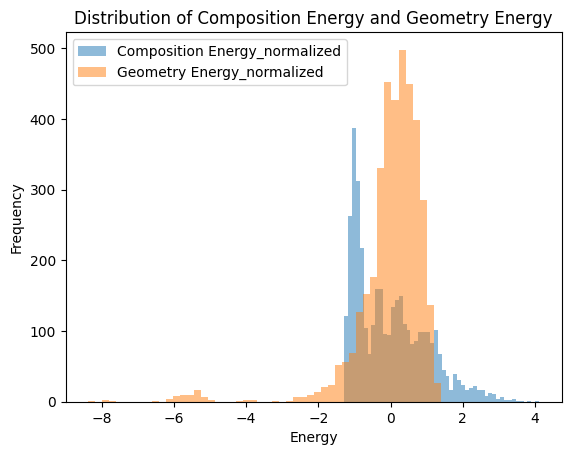

<Figure size 640x480 with 0 Axes>

In [9]:

import matplotlib.pyplot as plt

# Plotting the first distribution
plt.hist(new_dataset['composition_energy_normalized'], bins=50, alpha=0.5, label='Composition Energy_normalized')

# Plotting the second distribution
plt.hist(new_dataset['geometry_energy_normalized'], bins=50, alpha=0.5, label='Geometry Energy_normalized')

# Adding labels and title
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title('Distribution of Composition Energy and Geometry Energy')

# Adding legend
plt.legend()

# Display the plot
plt.show()
plt.savefig('composition_geometry_standardscaler.png')

In [50]:
max(new_dataset['geometry_energy'])

400.9651327784318

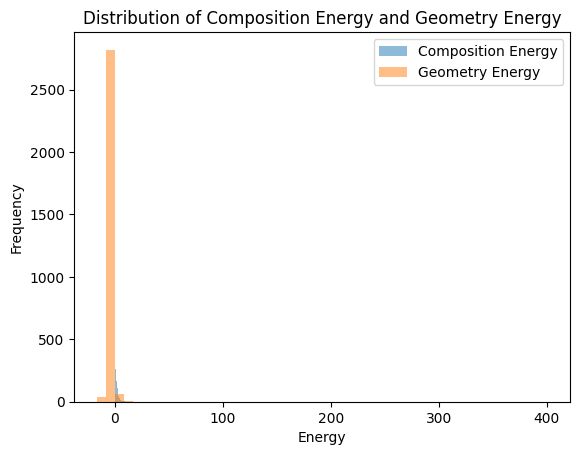

<Figure size 640x480 with 0 Axes>

In [54]:

import matplotlib.pyplot as plt

# Plotting the first distribution
plt.hist(new_dataset['composition_energy'], bins=50, alpha=0.5, label='Composition Energy')

# Plotting the second distribution
plt.hist(new_dataset['geometry_energy'], bins=50, alpha=0.5, label='Geometry Energy')

# Adding labels and title
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title('Distribution of Composition Energy and Geometry Energy')

# Adding legend
plt.legend()

# Display the plot
plt.show()
plt.savefig('composition_geometry_standardscaler.png')

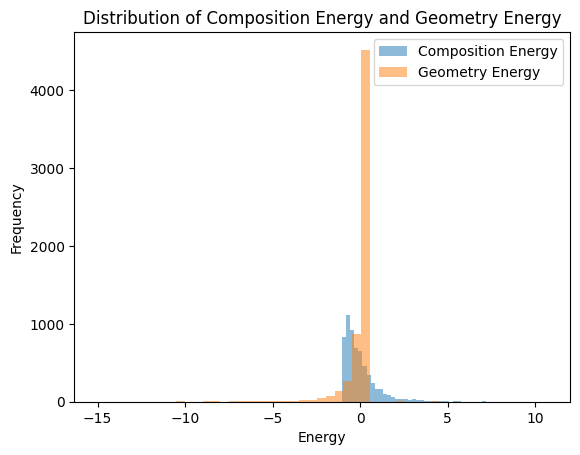

In [26]:
new_dataset_dict['geometry_energy_normalized'],dataset['geometry_energy']
import matplotlib.pyplot as plt

# Plotting the first distribution
plt.hist(new_dataset['composition_energy_normalized'], bins=50, alpha=0.5, label='Composition Energy')

# Plotting the second distribution
plt.hist(new_dataset['geometry_energy_normalized'], bins=50, alpha=0.5, label='Geometry Energy')

# Adding labels and title
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title('Distribution of Composition Energy and Geometry Energy')

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from datasets import Dataset
from datasets import load_dataset


#path= "/work/so87pot/material_db/qmof_text/qmof_filtered_text.json"
path="/work/so87pot/material_db/lp_exp/all/train_matbench_log_gvrh_0.json"
dataset = load_dataset("json", data_files=path,split="train")

# Assuming you have your dataset stored in a variable called 'dataset'

# Step 1: Normalize the features
scaler = MinMaxScaler()
composition_energy_reshaped = np.array(dataset['composition_energy']).reshape(-1, 1)
geometry_energy_reshaped = np.array(dataset['geometry_energy']).reshape(-1, 1)
normalized_features = scaler.fit_transform(composition_energy_reshaped)
normalized_geometry = scaler.fit_transform(geometry_energy_reshaped)



new_dataset = dataset.add_column('composition_energy_normalized', normalized_features.flatten())
new_dataset_2 = new_dataset.add_column('geometry_energy_normalized', normalized_geometry.flatten())


# Create a new dataset with the normalized features and geometry
# Convert new_dataset to a dictionary
new_dataset_dict = new_dataset_2.to_dict()

alphas = [0,0.2,0.4,0.5,0.6,0.8,1]
# Make the necessary modifications
for alpha in alphas:
    total_energy = alpha * np.array(new_dataset_dict['composition_energy_normalized']) + (1 - alpha) * np.array(new_dataset_dict['geometry_energy_normalized'])
    new_dataset_dict[f'total_energy_alpha_{alpha}'] = total_energy.tolist()

# Convert the modified dictionary back to a Dataset object
new_dataset_2 = Dataset.from_dict(new_dataset_dict)
new_dataset_2.to_json("/work/so87pot/material_db/lp_exp/norm/train_matbench_log_gvrh_0.json")


/home/so87pot/miniconda3/envs/slice_llm/lib/python3.9/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


Creating json from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

21114990

In [ ]:
/work/so87pot/material_db/lp_exp/all/train_matbench_log_gvrh_0.json

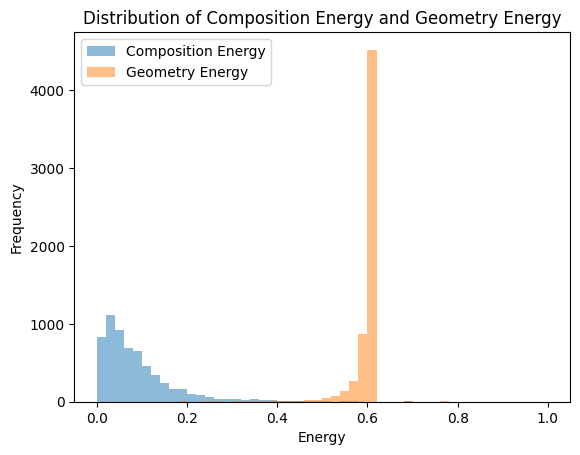

In [35]:
new_dataset_dict['geometry_energy_normalized'],dataset['geometry_energy']
import matplotlib.pyplot as plt

# Plotting the first distribution
plt.hist(new_dataset_2['composition_energy_normalized'], bins=50, alpha=0.5, label='Composition Energy')

# Plotting the second distribution
plt.hist(new_dataset_2['geometry_energy_normalized'], bins=50, alpha=0.5, label='Geometry Energy')

# Adding labels and title
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title('Distribution of Composition Energy and Geometry Energy')

# Adding legend
plt.legend()

# Display the plot
plt.show()

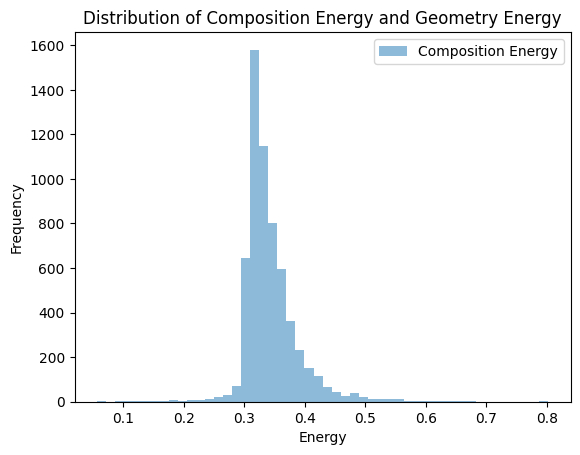

In [36]:
new_dataset_dict['geometry_energy_normalized'],dataset['geometry_energy']
import matplotlib.pyplot as plt

# Plotting the first distribution
plt.hist(new_dataset_2['total_energy_alpha_0.5'], bins=50, alpha=0.5, label='Composition Energy')


# Adding labels and title
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title('Distribution of Composition Energy and Geometry Energy')

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [27]:
path="/Users/n0w0f/git/MatText/notebooks/processed_data/gvrh-test-filtered_processed.json"
dataset = load_dataset("json", data_files=path,split="train")

Generating train split: 1528 examples [00:00, 46080.98 examples/s]


In [28]:
ds

Dataset({
    features: ['mbid', 'zmatrix', 'atoms_params', 'local_env', 'cif_p1', 'composition', 'crystal_llm_rep', 'composition_energy', 'geometry_energy'],
    num_rows: 1528
})

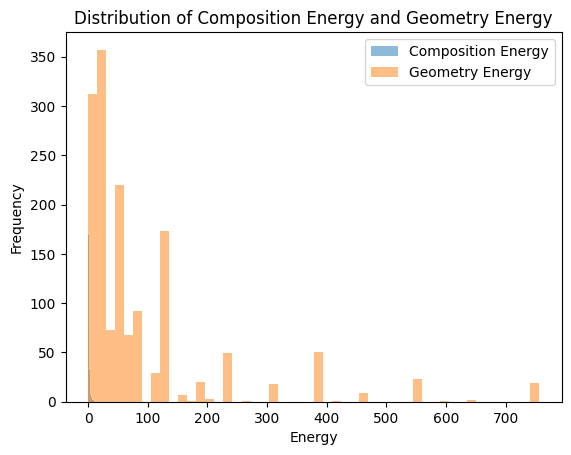

<Figure size 640x480 with 0 Axes>

In [29]:
#new_dataset_dict['geometry_energy_normalized'],dataset['geometry_energy']
import matplotlib.pyplot as plt

# Plotting the first distribution
plt.hist(ds['composition_energy'], bins=50, alpha=0.5, label='Composition Energy')

# Plotting the second distribution
plt.hist(ds['geometry_energy'], bins=50, alpha=0.5, label='Geometry Energy')

# Adding labels and title
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title('Distribution of Composition Energy and Geometry Energy')

# Adding legend
plt.legend()

# Display the plot
plt.show()
plt.savefig("composition_geometry_energy.png")

In [21]:
ds['geometry_energy']

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 4,
 4,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 4,
 12,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8,
 0,
 0,
 4,
 4,
 0,
 0,
 0,
 4,
 20,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 20,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 12,
 0